Welcome to our exciting project where we aim to revolutionize game-based learning. As someone who is passionate about education and technology, I am thrilled to be a part of this initiative. Our goal is to predict student performance during game-based learning in real-time, using one of the largest open datasets of game logs available.

Game-based learning is an innovative educational approach that has the potential to make learning fun and engaging. However, there are limited datasets available to apply data science and learning analytic principles to improve it. Therefore, we are challenging participants like you to develop a model that utilizes knowledge tracing to support individual students in educational games. By doing so, we hope to improve the effectiveness of game-based learning and make it more accessible to everyone.

As a participant, you will have the opportunity to contribute to advancing the field of educational technology and make a real difference in the lives of students. By enabling game developers to improve their games and providing educators with dashboards and analytic tools, we hope to create a world where game-based learning is widely supported and utilized.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score


from google.colab import files
import pandas as pd
import io




In [2]:
#Since the dataset it's to big, will try to reduce memory usage.
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

In [3]:
df = pd.read_csv('/content/drive/MyDrive/kaggle competitions/train.csv', dtype= dtypes)
labels = pd.read_csv('/content/drive/MyDrive/kaggle competitions/train_labels.csv')

#Data understanding

##dataset

In [4]:
#datasets 
df.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Columns: 20 entries, session_id to level_group
dtypes: category(10), float32(5), float64(1), int32(1), int64(2), uint8(1)
memory usage: 1.5 GB


In [5]:
df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int64   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           uint8   
 6   page            float64 
 7   room_coor_x     float32 
 8   room_coor_y     float32 
 9   screen_coor_x   float32 
 10  screen_coor_y   float32 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      category
 17  hq              category
 18  music           category
 19  level_group     category
dtypes: category(10), float32(5), float64(1), int32(1), int64(2), uint8(1)
memory usage: 1.5 GB


In [7]:
df.select_dtypes(include=np.number).describe().T

,count,mean,std,min,25%,50%,75%,max
session_id,26296946.0,2.113249e+16,5.712953e+14,2.009031e+16,2.101022e+16,2.104021e+16,2.110052e+16,2.210022e+16
index,26296946.0,6.445102e+02,5.457880e+02,0.000000e+00,2.880000e+02,5.950000e+02,8.960000e+02,2.047300e+04
elapsed_time,26296946.0,4.016694e+06,3.127032e+07,0.000000e+00,4.397000e+05,1.014801e+06,1.747040e+06,1.988607e+09
level,26296946.0,1.219169e+01,6.497789e+00,0.000000e+00,6.000000e+00,1.300000e+01,1.800000e+01,2.200000e+01
page,564544.0,3.166559e+00,2.063291e+00,0.000000e+00,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00
room_coor_x,24223674.0,-5.490582e+01,5.202926e+02,-1.992355e+03,-3.528395e+02,-1.116280e+01,2.966515e+02,1.261774e+03
room_coor_y,24223674.0,-1.162119e+02,2.184710e+02,-9.181624e+02,-2.127183e+02,-9.760534e+01,2.268786e+01,5.436164e+02
screen_coor_x,24223674.0,4.584099e+02,2.479389e+02,0.000000e+00,2.690000e+02,4.470000e+02,6.630000e+02,1.919000e+03
screen_coor_y,24223674.0,3.855858e+02,1.298166e+02,0.000000e+00,3.040000e+02,3.970000e+02,4.710000e+02,1.440000e+03
hover_duration,2002244.0,3.471006e+03,4.602024e+05,0.000000e+00,9.900000e+01,4.190000e+02,1.266000e+03,2.451637e+08


In [8]:
df.select_dtypes(exclude=np.number).describe().T

,count,unique,top,freq
event_name,26296946,11,navigate_click,11326433
name,26296946,6,undefined,12705785
text,9617139,597,undefined,355969
fqid,18022531,128,worker,1878958
room_fqid,26296946,19,tunic.historicalsociety.entry,3622003
text_fqid,9617244,126,tunic.historicalsociety.cage.confrontation,666557
fullscreen,26296946,2,0,22694166
hq,26296946,2,0,23135929
music,26296946,2,1,24439799
level_group,26296946,3,13-22,13471703


Here it's important to take a look in the frequency of the variables since it's acn show us whether a variable will be representative for the model

In [9]:
#Nan values
df.isna().sum()

session_id               0
index                    0
elapsed_time             0
event_name               0
name                     0
level                    0
page              25732402
room_coor_x        2073272
room_coor_y        2073272
screen_coor_x      2073272
screen_coor_y      2073272
hover_duration    24294702
text              16679807
fqid               8274415
room_fqid                0
text_fqid         16679702
fullscreen               0
hq                       0
music                    0
level_group              0
dtype: int64

## Labels columns

In [10]:
labels

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1
...,...,...
424111,22100215342220508_q18,1
424112,22100215460321130_q18,1
424113,22100217104993650_q18,1
424114,22100219442786200_q18,1


In [11]:
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

The goal in this porblem it's to predict whether the user will corretly anwser the question or not whatever the input session information.

<Axes: xlabel='correct', ylabel='count'>

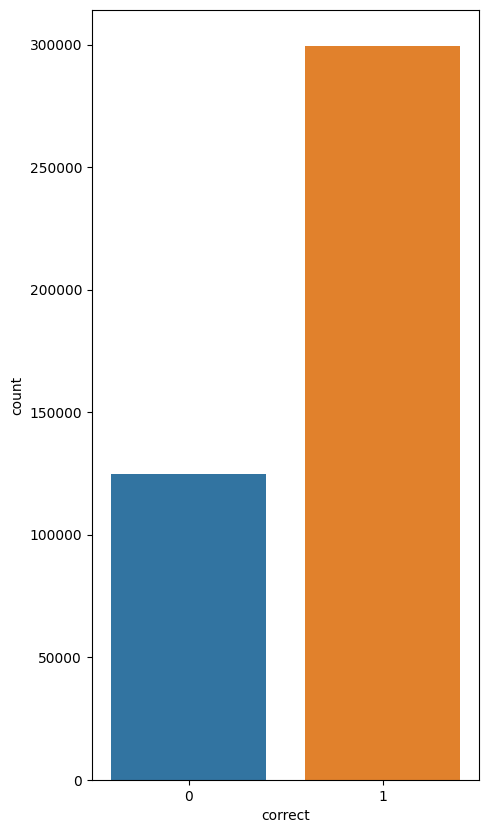

In [12]:
plt.figure(figsize=(5, 10))
sns.countplot(data  = labels, x= labels['correct'])


Our target it's unbalance meaning that our model could learn more about the correct anwsers than with the incorrect ones (the model may be biased towards the majority class and may perform poorly on the minority class).
Will present some solutions for this problem to avoid it.

In [13]:
labels['correct'].value_counts(normalize=True)

1    0.705635
0    0.294365
Name: correct, dtype: float64

###Categorical analysis

In [14]:
df.select_dtypes(exclude=np.number).columns

Index(['event_name', 'name', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'fullscreen', 'hq', 'music', 'level_group'],
      dtype='object')

In [15]:
for i in df.select_dtypes(exclude=np.number).columns:
  print('\n', df[i].value_counts())


 navigate_click        11326433
person_click           6052853
cutscene_click         2703035
object_click           2198211
object_hover           1057085
map_hover               945159
notification_click      649001
notebook_click          564544
map_click               517242
observation_click       212355
checkpoint               71028
Name: event_name, dtype: int64

 undefined    12705785
basic        12648469
close          676696
open           235139
prev            19250
next            11607
Name: name, dtype: int64

 undefined                                      355969
\u00f0\u0178\u02dc\u0090                        48805
Hey!                                            47452
I should go to the Capitol and tell Mrs. M!     40463
This is perfect for the exhibit.                40218
                                                ...  
I figured out that you kidnapped him!               1
Here I am!                                          1
He needs our help!               

In [16]:
def countplot(column):
  sns.countplot(data =df, x=df[column])
  plt.show()

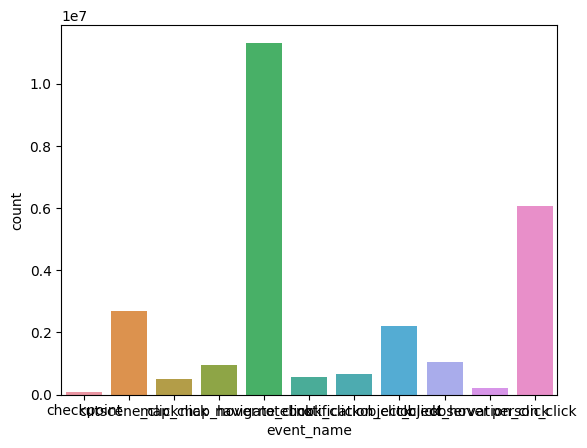

None


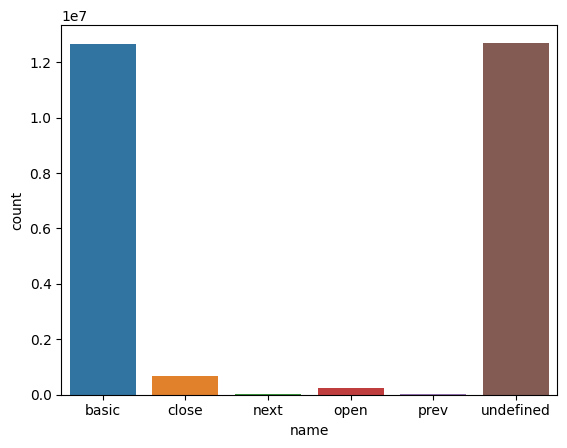

None


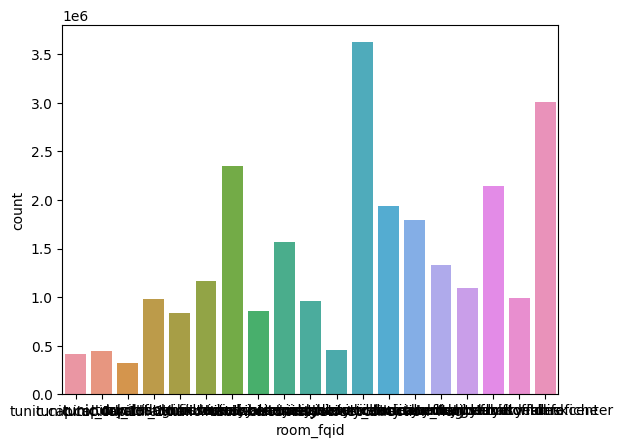

None


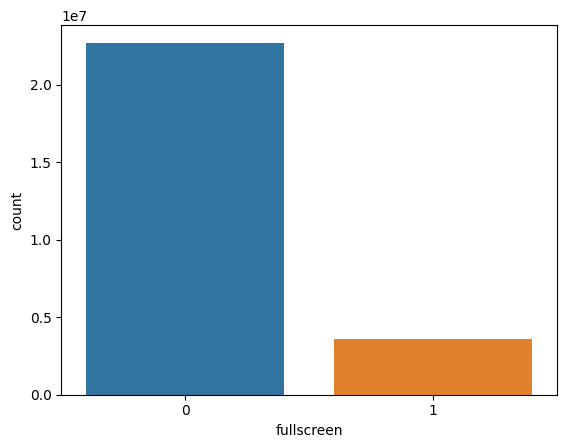

None


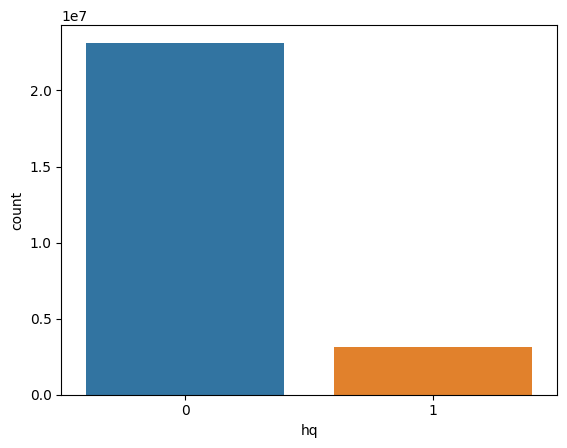

None


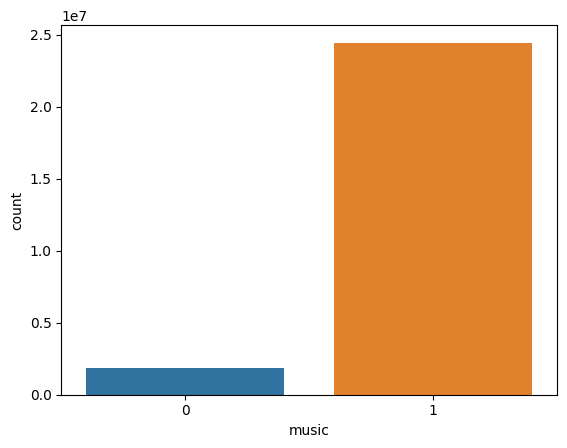

None


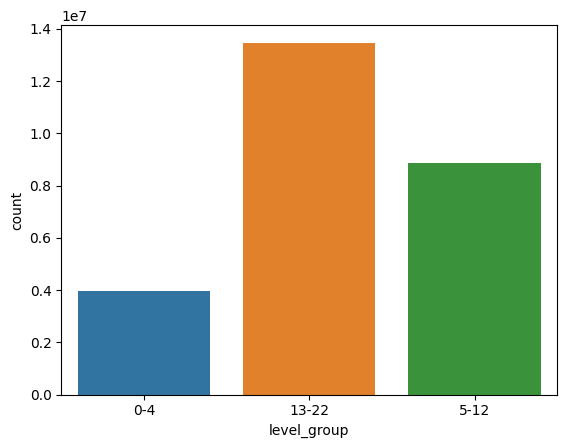

None


In [17]:
plt.figsize=(15, 5)

for i in ['event_name', 'name', 'room_fqid', 'fullscreen', 'hq', 'music', 'level_group']:
  print(countplot(i))

###Nuerical analysis

In [18]:
#for i in df.select_dtypes(include=np.number).columns:
 # print(sns.kdeplot(df[i]))

In [19]:
corr= df.corr()
corr.style.background_gradient(cmap= 'coolwarm')

<ipython-input-19-ca73bbc08085>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr= df.corr()


,session_id,index,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration
session_id,1.000000,-0.037144,0.023360,-0.002836,0.013753,-0.000144,-0.003722,0.007001,0.011294,0.001839
index,-0.037144,1.000000,0.077711,0.658861,0.358802,-0.008766,-0.157396,0.026612,0.029549,-0.002083
elapsed_time,0.023360,0.077711,1.000000,0.077311,0.076106,-0.002819,-0.018350,0.000510,0.001004,0.017643
level,-0.002836,0.658861,0.077311,1.000000,0.950965,-0.048372,-0.238980,0.031689,0.048497,-0.002294
page,0.013753,0.358802,0.076106,0.950965,1.000000,0.004870,-0.095950,0.008742,-0.004217,nan
room_coor_x,-0.000144,-0.008766,-0.002819,-0.048372,0.004870,1.000000,0.079033,0.687503,-0.174644,nan
room_coor_y,-0.003722,-0.157396,-0.018350,-0.238980,-0.095950,0.079033,1.000000,0.090904,-0.773422,nan
screen_coor_x,0.007001,0.026612,0.000510,0.031689,0.008742,0.687503,0.090904,1.000000,-0.119515,nan
screen_coor_y,0.011294,0.029549,0.001004,0.048497,-0.004217,-0.174644,-0.773422,-0.119515,1.000000,nan
hover_duration,0.001839,-0.002083,0.017643,-0.002294,nan,nan,nan,nan,nan,1.000000


##Label dataset

In [20]:
grouped_df = labels.groupby(['q', 'correct']).size().reset_index(name='count')

In [21]:
grouped_df

,q,correct,count
0,1,0,6421
1,1,1,17141
2,2,0,499
3,2,1,23063
4,3,0,1555
5,3,1,22007
6,4,0,4754
7,4,1,18808
8,5,0,10644
9,5,1,12918


<Axes: xlabel='correct'>

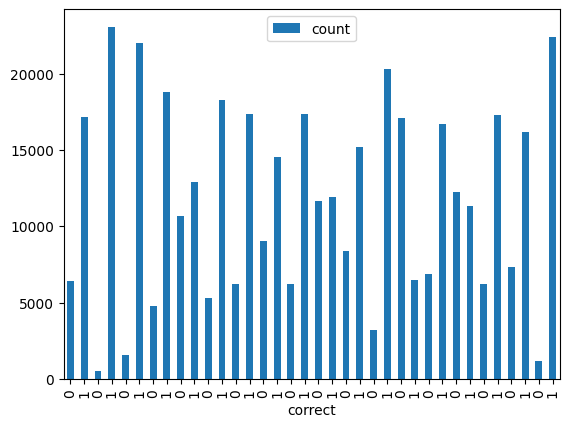

In [22]:
grouped_df.plot(kind='bar', x= 'correct', y='count')

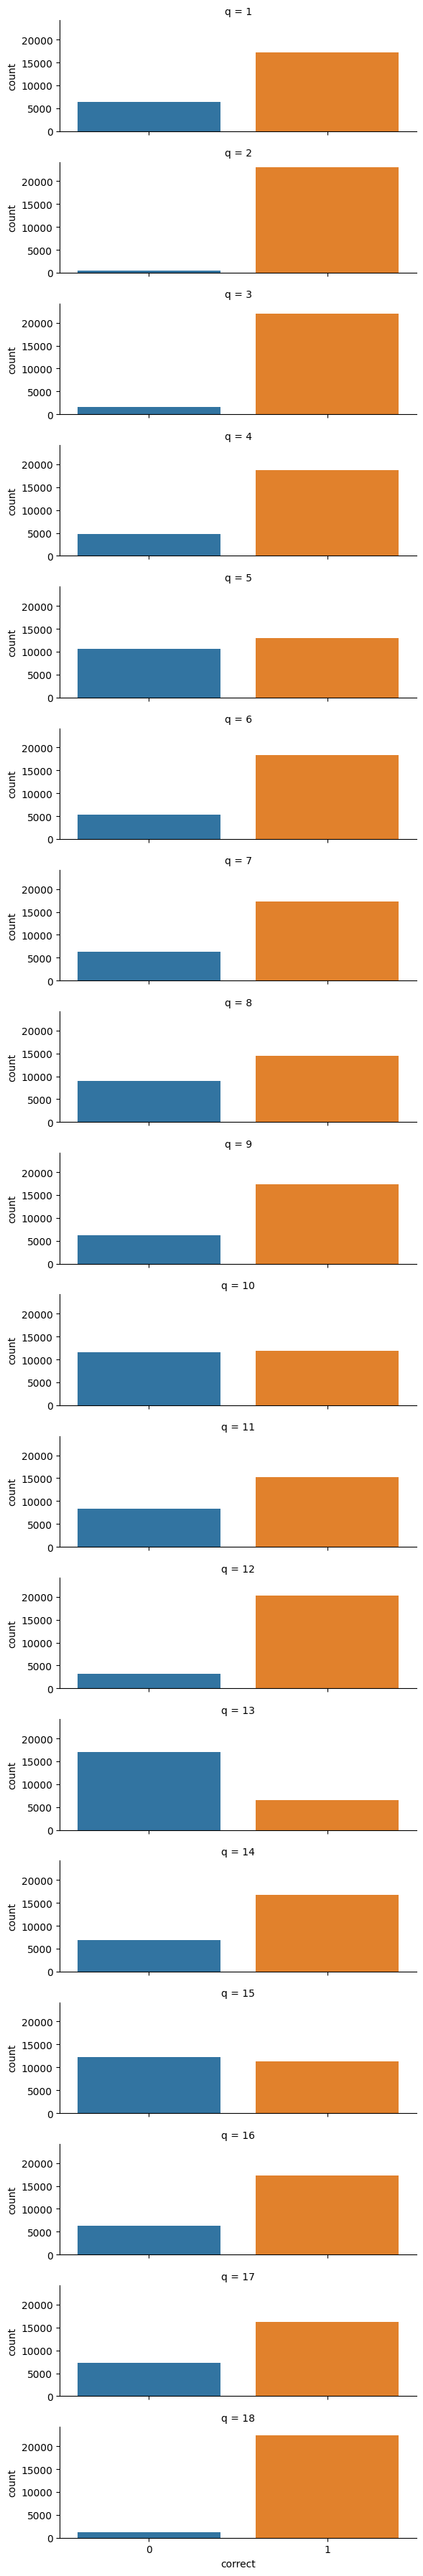

In [23]:
sns.catplot(data=grouped_df, x='correct', y='count', row='q', kind='bar', height=2, aspect=3)

It can be obsererved who there is a lack of observation in the incorrect anwsers compared to the correct ones

#Data preparation

In [24]:
df.select_dtypes(include=np.number).columns

Index(['session_id', 'index', 'elapsed_time', 'level', 'page', 'room_coor_x',
       'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration'],
      dtype='object')

In [25]:
df.select_dtypes(exclude=np.number).columns

Index(['event_name', 'name', 'text', 'fqid', 'room_fqid', 'text_fqid',
       'fullscreen', 'hq', 'music', 'level_group'],
      dtype='object')

In [26]:
categorical_var = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid', 'hq', 'music', 'level_group']
numerical_var = ['elapsed_time','level','page','room_coor_x', 'room_coor_y','screen_coor_x', 'screen_coor_y', 'hover_duration']

In [27]:
def df_transformation(dataset):

  categorical_nunique = dataset.groupby(['session_id', 'level_group'])[categorical_var].nunique().add_suffix('_nunique')
  numeric_std= dataset.groupby(['session_id', 'level_group'])[numerical_var].std().add_suffix('_std')
  numeric_mean= dataset.groupby(['session_id', 'level_group'])[numerical_var].mean().add_suffix('_mean')


  results= pd.concat([categorical_nunique,numeric_std,  numeric_mean], axis=1).fillna(-9)
  results.index.name = 'session_id'
  return results

  



In [28]:
df_1 = df_transformation(df)
df_1


event_name_nunique  name_nunique  fqid_nunique  \
session_id        level_group                                                   
20090312431273200 0-4                          10             3            30   
                  13-22                        10             3            49   
                  5-12                         10             3            39   
20090312433251036 0-4                          11             4            22   
                  13-22                        11             6            73   
...                                           ...           ...           ...   
22100219442786200 13-22                        11             4            49   
                  5-12                         11             6            41   
22100221145014656 0-4                          11             4            27   
                  13-22                        11             4            54   
                  5-12                         11             6            47   

                               room_fqid_nunique  text_fqid_nunique  \
session_id        level_group                                         
20090312431273200 0-4                          7                 17   
                  13-22                       12                 35   
                  5-12                        11                 24   
20090312433251036 0-4                          6                 11   
                  13-22                       16                 43   
...                                          ...                ...   
22100219442786200 13-22                       12                 33   
                  5-12                        11                 20   
22100221145014656 0-4                          7                 17   
                  13-22                       13                 36   
                  5-12                        12                 26   

                               hq_nunique  music_nunique  level_group_nunique  \
session_id        level_group                                                   
20090312431273200 0-4                   1              1                    1   
                  13-22                 1              1                    1   
                  5-12                  1              1                    1   
20090312433251036 0-4                   1              1                    1   
                  13-22                 1              1                    1   
...                                   ...            ...                  ...   
22100219442786200 13-22                 1              1                    1   
                  5-12                  1              1                    1   
22100221145014656 0-4                   1              1                    1   
                  13-22                 1              1                    1   
                  5-12                  1              1                    1   

                               elapsed_time_std  level_std  ...  \
session_id        level_group                               ...   
20090312431273200 0-4              4.924654e+04   1.230975  ...   
                  13-22            1.266661e+05   2.358652  ...   
                  5-12             8.017568e+04   2.096919  ...   
20090312433251036 0-4              6.737271e+04   1.232616  ...   
                  13-22            7.773825e+05   1.825923  ...   
...                                         ...        ...  ...   
22100219442786200 13-22            1.516019e+05   2.359474  ...   
                  5-12             9.665042e+04   2.180934  ...   
22100221145014656 0-4              1.085422e+05   1.276526  ...   
                  13-22            3.370855e+05   2.210473  ...   
                  5-12             1.347404e+06   2.198412  ...   

                               screen_coor_y_std  hover_duration_std  \
session_id        level_group                          

In [29]:
df_1.index

MultiIndex([(20090312431273200,   '0-4'),
            (20090312431273200, '13-22'),
            (20090312431273200,  '5-12'),
            (20090312433251036,   '0-4'),
            (20090312433251036, '13-22'),
            (20090312433251036,  '5-12'),
            (20090312455206810,   '0-4'),
            (20090312455206810, '13-22'),
            (20090312455206810,  '5-12'),
            (20090313091715820,   '0-4'),
            ...
            (22100215460321130,  '5-12'),
            (22100217104993650,   '0-4'),
            (22100217104993650, '13-22'),
            (22100217104993650,  '5-12'),
            (22100219442786200,   '0-4'),
            (22100219442786200, '13-22'),
            (22100219442786200,  '5-12'),
            (22100221145014656,   '0-4'),
            (22100221145014656, '13-22'),
            (22100221145014656,  '5-12')],
           name='session_id', length=70686)

##Numeric variable analysis

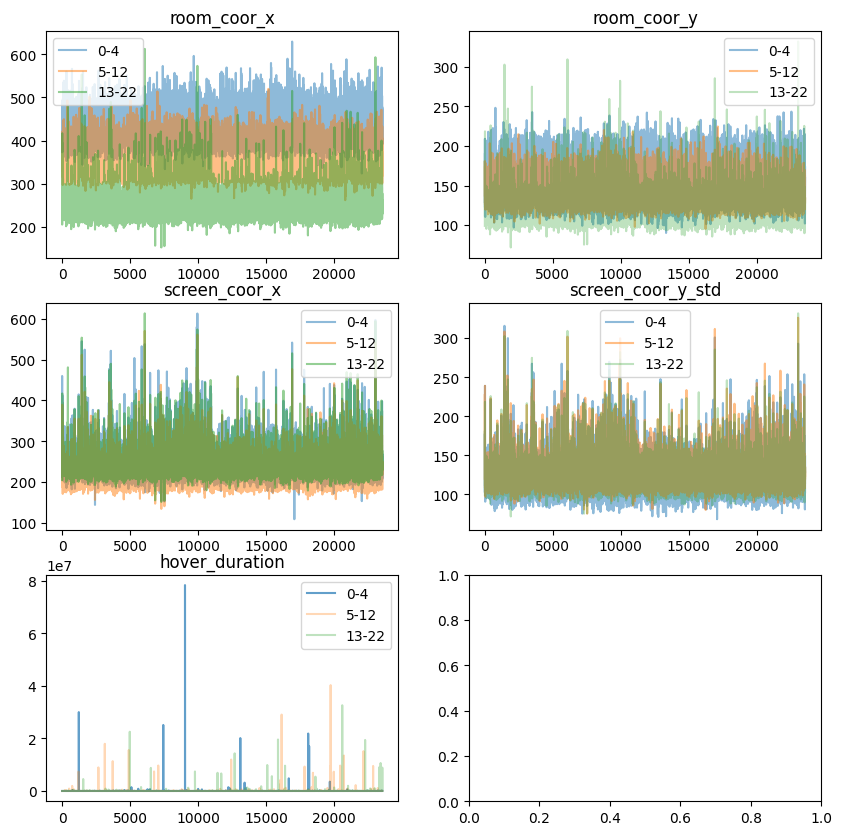

In [30]:
figure, axis = plt.subplots(3, 2, figsize=(10, 10))

grouped_data = df_1.groupby('level_group')

# Plotting room_coor_x_std
axis[0, 0].plot(range(1, len(grouped_data.get_group('0-4')['room_coor_x_std'])+1), 
                grouped_data.get_group('0-4')['room_coor_x_std'], label='0-4', alpha=0.5)
axis[0, 0].plot(range(1, len(grouped_data.get_group('5-12')['room_coor_x_std'])+1), 
                grouped_data.get_group('5-12')['room_coor_x_std'], label='5-12', alpha=0.5)
axis[0, 0].plot(range(1, len(grouped_data.get_group('13-22')['screen_coor_x_std'])+1),
               grouped_data.get_group('13-22')['screen_coor_x_std'], label= '13-22', alpha=0.5)
axis[0, 0].set_title('room_coor_x')
axis[0, 0].legend()

# Plotting room_coor_y_std
axis[0, 1].plot(range(1, len(grouped_data.get_group('0-4')['room_coor_y_std'])+1), 
                grouped_data.get_group('0-4')['room_coor_y_std'], label='0-4', alpha=0.5)
axis[0, 1].plot(range(1, len(grouped_data.get_group('5-12')['room_coor_y_std'])+1), 
                grouped_data.get_group('5-12')['room_coor_y_std'], label='5-12', alpha=0.5)
axis[0, 1].plot(range(1, len(grouped_data.get_group('13-22')['screen_coor_y_std'])+1),
               grouped_data.get_group('13-22')['screen_coor_y_std'], label= '13-22', alpha=0.3)
axis[0, 1].set_title('room_coor_y')
axis[0, 1].legend()

# Plotting screen_coor_x_std
axis[1, 0].plot(range(1, len(grouped_data.get_group('0-4')['screen_coor_x_std'])+1), 
                grouped_data.get_group('0-4')['screen_coor_x_std'], label='0-4', alpha=0.5)
axis[1, 0].plot(range(1, len(grouped_data.get_group('5-12')['screen_coor_x_std'])+1), 
                grouped_data.get_group('5-12')['screen_coor_x_std'], label='5-12', alpha=0.5)
axis[1, 0].plot(range(1, len(grouped_data.get_group('13-22')['screen_coor_x_std'])+1),
               grouped_data.get_group('13-22')['screen_coor_x_std'], label= '13-22', alpha=0.5)
axis[1, 0].set_title('screen_coor_x')
axis[1, 0].legend()

# Plotting screen_coor_y_std
axis[1, 1].plot(range(1, len(grouped_data.get_group('0-4')['screen_coor_y_std'])+1), 
                grouped_data.get_group('0-4')['screen_coor_y_std'], label='0-4', alpha=0.5)
axis[1, 1].plot(range(1, len(grouped_data.get_group('5-12')['screen_coor_y_std'])+1), 
                grouped_data.get_group('5-12')['screen_coor_y_std'], label='5-12', alpha=0.5)
axis[1,1].plot(range(1, len(grouped_data.get_group('13-22')['screen_coor_y_std'])+1),
               grouped_data.get_group('13-22')['screen_coor_y_std'], label= '13-22', alpha=0.3)
axis[1, 1].set_title('screen_coor_y_std')
axis[1, 1].legend()

# Plotting hover_duration_std
axis[2, 0].plot(range(1, len(grouped_data.get_group('0-4')['hover_duration_std'])+1), 
                grouped_data.get_group('0-4')['hover_duration_std'], label='0-4', alpha=0.7)
axis[2, 0].plot(range(1, len(grouped_data.get_group('5-12')['hover_duration_std'])+1), 
                grouped_data.get_group('5-12')['hover_duration_std'], label='5-12', alpha=0.3)
axis[2, 0].plot(range(1, len(grouped_data.get_group('13-22')['hover_duration_std'])+1),
               grouped_data.get_group('13-22')['hover_duration_std'], label= '13-22', alpha=0.3)
axis[2, 0].set_title('hover_duration')
axis[2, 0].legend()

#Plotting elapsetime


#Splitting data

In [31]:
df_1

event_name_nunique  name_nunique  fqid_nunique  \
session_id        level_group                                                   
20090312431273200 0-4                          10             3            30   
                  13-22                        10             3            49   
                  5-12                         10             3            39   
20090312433251036 0-4                          11             4            22   
                  13-22                        11             6            73   
...                                           ...           ...           ...   
22100219442786200 13-22                        11             4            49   
                  5-12                         11             6            41   
22100221145014656 0-4                          11             4            27   
                  13-22                        11             4            54   
                  5-12                         11             6            47   

                               room_fqid_nunique  text_fqid_nunique  \
session_id        level_group                                         
20090312431273200 0-4                          7                 17   
                  13-22                       12                 35   
                  5-12                        11                 24   
20090312433251036 0-4                          6                 11   
                  13-22                       16                 43   
...                                          ...                ...   
22100219442786200 13-22                       12                 33   
                  5-12                        11                 20   
22100221145014656 0-4                          7                 17   
                  13-22                       13                 36   
                  5-12                        12                 26   

                               hq_nunique  music_nunique  level_group_nunique  \
session_id        level_group                                                   
20090312431273200 0-4                   1              1                    1   
                  13-22                 1              1                    1   
                  5-12                  1              1                    1   
20090312433251036 0-4                   1              1                    1   
                  13-22                 1              1                    1   
...                                   ...            ...                  ...   
22100219442786200 13-22                 1              1                    1   
                  5-12                  1              1                    1   
22100221145014656 0-4                   1              1                    1   
                  13-22                 1              1                    1   
                  5-12                  1              1                    1   

                               elapsed_time_std  level_std  ...  \
session_id        level_group                               ...   
20090312431273200 0-4              4.924654e+04   1.230975  ...   
                  13-22            1.266661e+05   2.358652  ...   
                  5-12             8.017568e+04   2.096919  ...   
20090312433251036 0-4              6.737271e+04   1.232616  ...   
                  13-22            7.773825e+05   1.825923  ...   
...                                         ...        ...  ...   
22100219442786200 13-22            1.516019e+05   2.359474  ...   
                  5-12             9.665042e+04   2.180934  ...   
22100221145014656 0-4              1.085422e+05   1.276526  ...   
                  13-22            3.370855e+05   2.210473  ...   
                  5-12             1.347404e+06   2.198412  ...   

                               screen_coor_y_std  hover_duration_std  \
session_id        level_group                          

In [32]:
x_train, x_val = train_test_split(df_1, random_state=42, test_size=0.2)
print('{} train size, {} val size'.format(len(x_train), len(x_val)))

56548 train size, 14138 val size


In [33]:
x_val.reset_index(inplace=True)
x_val.set_index('session_id', inplace=True)

In [34]:
x_val

,level_group,event_name_nunique,name_nunique,fqid_nunique,room_fqid_nunique,text_fqid_nunique,hq_nunique,music_nunique,level_group_nunique,elapsed_time_std,...,screen_coor_y_std,hover_duration_std,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,room_coor_y_mean,screen_coor_x_mean,screen_coor_y_mean,hover_duration_mean
session_id,,,,,,,,,,,,,,,,,,,,,
21010114474092640,5-12,10,3,38,11,20,1,1,1,107323.533264,...,111.692922,1821.916363,4.168234e+05,8.157343,-9.000000,-55.821674,-21.697962,404.816742,344.326691,1202.911743
21000110383824564,13-22,11,4,54,13,30,1,1,1,96429.041139,...,119.852035,698.023559,2.117683e+06,18.291815,5.764706,-71.833229,-131.615112,478.082703,374.953857,587.243896
21030111250075360,5-12,10,3,46,12,28,1,1,1,173196.771693,...,124.884538,2729.556093,5.512676e+05,8.556627,-9.000000,19.364393,4.384662,460.358093,325.668427,1782.918945
22070315382744588,0-4,10,3,23,6,14,1,1,1,59841.346912,...,120.477907,2622.754023,1.009384e+05,1.798387,-9.000000,38.068932,-111.906143,455.487396,413.563019,2569.000000
22090219034194660,13-22,10,3,47,12,26,1,1,1,612968.382923,...,124.829379,1129.560589,1.126571e+06,17.978916,-9.000000,-100.786575,-133.421753,475.091492,363.379089,952.960022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22040421345249300,0-4,11,4,25,7,14,1,1,1,76184.441387,...,108.926408,2978.530636,1.528843e+05,2.010152,0.000000,-35.429028,-45.655136,451.818176,362.641724,2020.333374
21050513174429650,0-4,9,3,21,6,13,1,1,1,27758.962100,...,102.166808,1098.136831,4.628524e+04,1.913333,-9.000000,15.518068,-21.294308,441.993195,346.442169,826.500000
21040513361113644,13-22,10,3,53,13,37,1,1,1,299089.246430,...,98.095331,964.105353,1.661969e+06,18.105660,-9.000000,-78.708122,-187.721802,480.532562,415.794495,553.553406


In [35]:
x_train.reset_index(inplace=True)
x_train.set_index('session_id', inplace=True)

##Training the model

Here we have to keep in mind that we have 18 different questions , so we have to train 18 different times our model to predict whether each question will be correct or not.
Let's try it with one question belonging to the second group.

In [36]:
#saving results

models = {}
evaluation_dict = {}

In [37]:
prediction_df = pd.DataFrame(data=np.zeros((len(x_val.index.unique()),18)), index=x_val.index.unique())

In [38]:
prediction_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
21010114474092640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21000110383824564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21030111250075360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22070315382744588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22090219034194660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020212535485710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22040421345249300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21050513174429650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
for q_no in range(1, 19):
    if q_no <= 3:
        grp = '0-4'
    elif q_no <= 13:
        grp = '5-12'
    else:
        grp = '13-22'
    print("### q_no", q_no, "grp", grp)
    
    # Filter the rows in the datasets based on the selected level group.
    train_df = x_train[x_train.level_group == grp].drop('level_group', axis=1)
    train_users = train_df.index.values
    valid_df = x_val[x_val.level_group == grp].drop('level_group', axis=1)
    valid_users = valid_df.index.values
    
    # Select the labels for the related q_no.
    train_labels = labels[labels.q == q_no].set_index('session').loc[train_users]
    valid_labels = labels[labels.q == q_no].set_index('session').loc[valid_users]
    
    common_cols = set(train_df.columns).intersection(set(valid_df.columns))
    train_df = train_df[common_cols]
    valid_df = valid_df[common_cols]
    
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]
    
    X_train, y_train = train_df.loc[:, train_df.columns != 'correct'], train_labels['correct']
    X_valid, y_valid = valid_df.loc[:, valid_df.columns != 'correct'], valid_labels['correct']
    
    # Define parameters for XGBoost model
    params = {
        
         'objective': 'binary:logistic',
         'eval_metric': 'auc'
         
         }
         
         # Train the model
    num_rounds = 100
    model = xgb.XGBClassifier(params=params,  random_state=42)
    model.fit(X_train, y_train)
    
    # Store the model
    models[f'{grp}_{q_no}'] = model
    
    # Use the trained model to make predictions on the validation dataset and store the predicted values in the `prediction_df` dataframe.
    prediction = model.predict_proba(X_valid)[:, 1]
    prediction_df.loc[valid_users, q_no-1] = prediction
    
    # Evaluate the trained model on the validation dataset and store the evaluation accuracy in the `evaluation_dict`.
    threshold = 0.5
    binary_predictions = [int(p > threshold) for p in prediction]
    accuracy = accuracy_score(y_valid, binary_predictions)
    evaluation_dict[q_no] = accuracy

### q_no 1 grp 0-4
[21:07:53] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 2 grp 0-4
[21:08:01] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 3 grp 0-4
[21:08:06] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 4 grp 5-12
[21:08:14] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 5 grp 5-12
[21:08:19] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 6 grp 5-12
[21:08:27] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 7 grp 5-12
[21:08:35] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 8 grp 5-12
[21:08:40] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 9 grp 5-12
[21:08:48] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 10 grp 5-12
[21:08:53] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 11 grp 5-12
[21:09:01] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 12 grp 5-12
[21:09:06] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 13 grp 5-12
[21:09:14] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 14 grp 13-22
[21:09:20] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 15 grp 13-22
[21:09:27] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 16 grp 13-22
[21:09:33] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 17 grp 13-22
[21:09:41] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


### q_no 18 grp 13-22
[21:09:46] WARNING: ../src/learner.cc:767: 
Parameters: { "params" } are not used.



<ipython-input-39-2268f8d7efe0>:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  train_df = train_df[common_cols]
<ipython-input-39-2268f8d7efe0>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  valid_df = valid_df[common_cols]


In [40]:
prediction_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
21010114474092640,0.000000,0.000000,0.000000,0.958678,0.754060,0.906494,0.808107,0.842491,0.943333,0.714375,0.745487,0.741035,0.666450,0.932645,0.736080,0.812040,0.765419,0.998895
21000110383824564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.532292,0.297431,0.891279,0.625580,0.996384
21030111250075360,0.000000,0.000000,0.000000,0.884247,0.347063,0.698378,0.844943,0.772684,0.592517,0.451379,0.518337,0.936468,0.084985,0.000000,0.000000,0.000000,0.000000,0.000000
22070315382744588,0.861507,0.998030,0.969768,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22090219034194660,0.000000,0.000000,0.000000,0.891851,0.734232,0.875445,0.949455,0.953223,0.954430,0.802683,0.753851,0.761267,0.197721,0.578093,0.368386,0.951195,0.861535,0.959680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020212535485710,0.000000,0.000000,0.000000,0.774085,0.634366,0.842734,0.773924,0.601628,0.735538,0.559759,0.729849,0.716104,0.388596,0.000000,0.000000,0.000000,0.000000,0.000000
22040421345249300,0.597998,0.998709,0.964064,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21050513174429650,0.857987,0.999609,0.983324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [41]:
accuracy

0.9495335029686175

In [42]:
f1_score(binary_predictions, y_valid)

0.9741079199303743

In [43]:
prediction

array([0.9963844 , 0.9596802 , 0.99690956, ..., 0.97608167, 0.9961492 ,
       0.9500487 ], dtype=float32)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

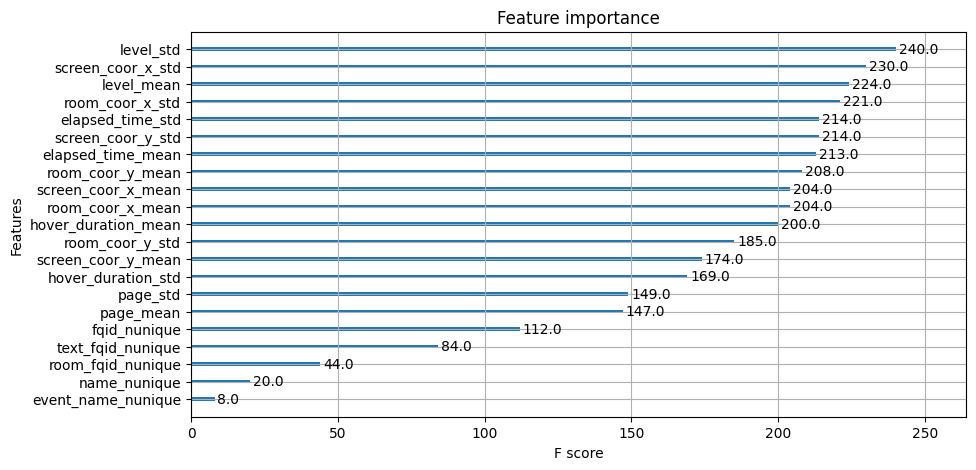

In [44]:
fig, ax= plt.subplots(figsize=(10,5))
xgb.plot_importance(model, ax=ax)


In [45]:
prediction

array([0.9963844 , 0.9596802 , 0.99690956, ..., 0.97608167, 0.9961492 ,
       0.9500487 ], dtype=float32)

In [46]:
prediction_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
21010114474092640,0.000000,0.000000,0.000000,0.958678,0.754060,0.906494,0.808107,0.842491,0.943333,0.714375,0.745487,0.741035,0.666450,0.932645,0.736080,0.812040,0.765419,0.998895
21000110383824564,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.532292,0.297431,0.891279,0.625580,0.996384
21030111250075360,0.000000,0.000000,0.000000,0.884247,0.347063,0.698378,0.844943,0.772684,0.592517,0.451379,0.518337,0.936468,0.084985,0.000000,0.000000,0.000000,0.000000,0.000000
22070315382744588,0.861507,0.998030,0.969768,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22090219034194660,0.000000,0.000000,0.000000,0.891851,0.734232,0.875445,0.949455,0.953223,0.954430,0.802683,0.753851,0.761267,0.197721,0.578093,0.368386,0.951195,0.861535,0.959680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020212535485710,0.000000,0.000000,0.000000,0.774085,0.634366,0.842734,0.773924,0.601628,0.735538,0.559759,0.729849,0.716104,0.388596,0.000000,0.000000,0.000000,0.000000,0.000000
22040421345249300,0.597998,0.998709,0.964064,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21050513174429650,0.857987,0.999609,0.983324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


As I look at the data, I can see that the values in the "correct" column are quite imbalanced. This means that simply using the default threshold of 0.5 to classify predictions as either 0 or 1 may not yield good results. To improve the accuracy of my predictions, I will need to calculate the F1 score across a range of thresholds and identify the threshold that produces the highest F1 score. This optimal threshold will be used to map the predicted probabilities to either class 0 or class 1.

It's important to note that when dealing with class imbalance, accuracy is not the best metric to use. Instead, I will be using the F1 score to evaluate the performance of my model.

In [55]:
thresholds = []
scores = [] 
true_df = pd.DataFrame(data=np.zeros((len(x_val.index.unique()),18)), index=x_val.index.unique())
for i in range(18):
    # Get the true labels.
    tmp = labels.loc[labels.q == i+1].set_index('session').loc[x_val.index.unique()]
    true_df[i] = tmp.correct.values

max_score = 0
best_threshold = 0

# Loop through threshold values from 0.4 to 0.8 and select the threshold with 
# the highest `F1 score`.
for threshold in np.arange(0.4, 0.8, 0.01):
    # Reshape the data
    y_true = true_df.values.reshape(-1)
    y_pred = (prediction_df.values.reshape((-1)) > threshold).astype('int')
    
    
    # Compute the F1 score
    f1_score_xgb = f1_score(y_true, y_pred, average='macro')
    thresholds.append(threshold)
    scores.append(f1_score_xgb)
    
    if f1_score_xgb > max_score:
        max_score = f1_score_xgb
        best_threshold = threshold
        
print("Best threshold ", best_threshold, "\tF1 score ", max_score)


Best threshold  0.4700000000000001 	F1 score  0.4719681389151875


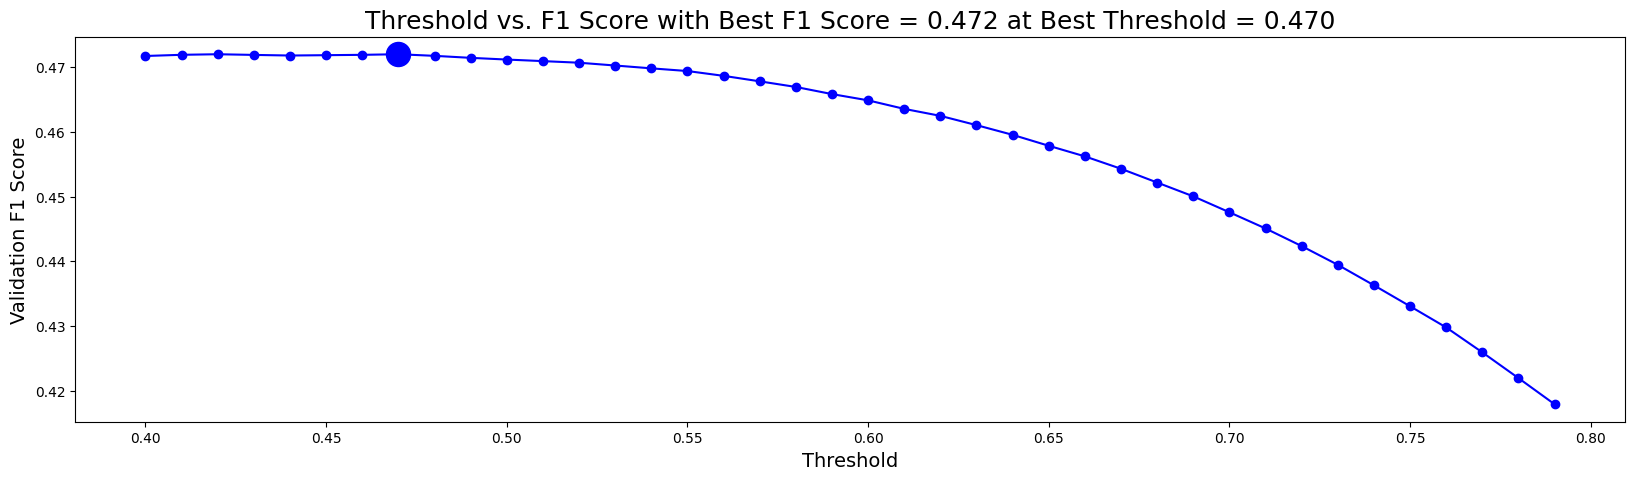

In [58]:
plt.figure(figsize=(20, 5))
plt.plot(thresholds, scores, '-o', color='blue')  # Plotting threshold vs. F1 score as a line plot
plt.scatter([best_threshold], [max_score], color='blue', s=300, alpha=1)  # Marking the best threshold and F1 score with a scatter point
plt.xlabel('Threshold', size=14)
plt.ylabel('Validation F1 Score', size=14)
plt.title(f'Threshold vs. F1 Score with Best F1 Score = {max_score:.3f} at Best Threshold = {best_threshold:.3f}', size=18)
plt.show()

Once we've found the optimal threslhold to transform our prediction into binary ones, our model is ready to make predictions with the optimal threshold. In order to present the results, we should have to make the predictions with the test set.